# Chuẩn bị một số thư viện sử dụng


In [29]:
import sys
!{sys.executable} -m pip install bio
!{sys.executable} -m pip install seaborn

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Bio import SeqIO
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
import tensorflow.keras.layers  as layers
import tensorflow.keras as keras
import os
import time

# Lấy dữ liệu để huấn luyện và đánh giá

In [32]:
data = pd.DataFrame()
columns = list(['sequence', 'confidence', 'strength'])


In [33]:
promoter = SeqIO.parse('/content/drive/MyDrive/Colab Notebooks/Promoter_positive2860.fasta', "fasta")
for seq_record in promoter:
    description = seq_record.description
    split_des = description.split(' ')
    strength = ''
    if split_des[-1]=='Weak':
        strength +='Weak'
    else:
        strength +='Strong'

    data = data.append({columns[0]: str(seq_record.seq).upper(),
                 columns[1]: 'promoter',columns[2]: strength}, ignore_index=True)
    # data = data.append({columns[0]: str(seq_record.seq).upper(),
    #                     columns[1]: 'promoter'}, ignore_index=True)


In [34]:
promoter = SeqIO.parse('/content/drive/MyDrive/Colab Notebooks/Promoter_negative2860.fasta', "fasta")
for seq_record in promoter:
    data = data.append({columns[0]: str(seq_record.seq).upper(),
                        columns[1]: 'non_promoter',columns[2]:'non'}, ignore_index=True)

In [35]:
data

,confidence,sequence,strength
0,promoter,CAACCAGCAAGAGAACATCTGGCCTGCGGGCACCACTGCTACAGTG...,Weak
1,promoter,CCGCGACCTTTGCCGCAAGCCTCGGTCTGAAAGTTAACGCCGGACA...,Weak
2,promoter,CAAGAGCTGGCGCGTATCGCCAAAGCCGCGACCTTTGCCGCAAGCC...,Weak
3,promoter,TAGATGTCCTTGATTAACACCAAAATTAAACCTTTTAAAAACCAGG...,Strong
4,promoter,TATTTTATCTACAAAAACTGACTAAATAAAAATTTTTCACTAATTG...,Weak
...,...,...,...
5715,non_promoter,CAACCTTTTACCTTAAGGTTCCGGAAGGCTGGTTCATTCCGGCTGA...,non
5716,non_promoter,GGGCAGGCAAAAAATCAATCTTGATCCCGATATCGTCCGCGTTGCC...,non
5717,non_promoter,TGATTTGTATGGAAAAAATCTATGCCTATGCGGGATATATCGCCAT...,non
5718,non_promoter,ACTCAGTCATTCCCGCGCCCGAGGAAGGTGAAACGGCAACGTTTAT...,non


# biểu diễn chuỗi trình tự gen thành các ma trận

chuỗi gen là trình tự sắp xếp các nucleotide A,T,G,C có độ dài l bao gồm {N0,N1,N2,N3...,N(l-1)}.
 Giả sử quy định 4 loại nucleotide được mã hoá lần lượt bằng 4 vector 4 chiều [1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1].

mã hoá chuỗi bằng cách thay thế nu bằng các vector ta sẽ được 1 ma trận 4xl cách này giống với one_hot trong xử lý ngôn ngữ tự nhiên.

Để dễ dàng áp dụng thuật toán CNN và RNN thì tất cả các chuỗi sẽ được mã hoá có độ dài bằng chuỗi nu dài nhất, nếu ngắn hơn sẽ được thêm vector [0,0,0,0]


In [36]:
max_len_seq = data['sequence'].apply(len).max()


In [37]:
one_nu = {
    'A':[1,0,0,0],
    'T':[0,1,0,0], 
    'G':[0,0,1,0],
    'C':[0,0,0,1]
}

In [38]:
def one_hot(seq):
    arr =np.array([])
    for nu in seq:  
        arr = np.concatenate((arr, np.array(one_nu[nu])), axis=0)
    return arr.reshape(int(len(arr)/4),4)


In [39]:
data['one_hot_seq']= data['sequence'].apply(lambda x:one_hot(x))

In [40]:
data['one_hot_seq'][0][0].shape

(4,)

# Mã hoá kết quả đầu ra

In [41]:

le_con = LabelEncoder()
le_con.fit(data['confidence'])
data['confidence'] = le_con.transform(data['confidence'])


In [42]:
le_strength = LabelEncoder()
le_strength.fit(data['strength'])
data['strength'] = le_strength.transform(data['strength'])


In [43]:
data

,confidence,sequence,strength,one_hot_seq
0,1,CAACCAGCAAGAGAACATCTGGCCTGCGGGCACCACTGCTACAGTG...,1,"[[0.0, 0.0, 0.0, 1.0], [1.0, 0.0, 0.0, 0.0], [..."
1,1,CCGCGACCTTTGCCGCAAGCCTCGGTCTGAAAGTTAACGCCGGACA...,1,"[[0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 1.0], [..."
2,1,CAAGAGCTGGCGCGTATCGCCAAAGCCGCGACCTTTGCCGCAAGCC...,1,"[[0.0, 0.0, 0.0, 1.0], [1.0, 0.0, 0.0, 0.0], [..."
3,1,TAGATGTCCTTGATTAACACCAAAATTAAACCTTTTAAAAACCAGG...,0,"[[0.0, 1.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [..."
4,1,TATTTTATCTACAAAAACTGACTAAATAAAAATTTTTCACTAATTG...,1,"[[0.0, 1.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [..."
...,...,...,...,...
5715,0,CAACCTTTTACCTTAAGGTTCCGGAAGGCTGGTTCATTCCGGCTGA...,2,"[[0.0, 0.0, 0.0, 1.0], [1.0, 0.0, 0.0, 0.0], [..."
5716,0,GGGCAGGCAAAAAATCAATCTTGATCCCGATATCGTCCGCGTTGCC...,2,"[[0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0], [..."
5717,0,TGATTTGTATGGAAAAAATCTATGCCTATGCGGGATATATCGCCAT...,2,"[[0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0], [..."
5718,0,ACTCAGTCATTCCCGCGCCCGAGGAAGGTGAAACGGCAACGTTTAT...,2,"[[1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0], [..."


# Tạo các bộ dữ liệu cho quá trình training và evaluate

lọc dữ liệu để lấy tập chứa hộp TaTa và không chứa hộp TaTa,chỉ chứa vùng khởi động gen

In [44]:
promoter_data = data[data['confidence']==1]

In [45]:
promoter_data = promoter_data[promoter_data['strength']!=2]

In [46]:
strong_data = promoter_data[promoter_data['strength']==0]
weak_data = promoter_data[promoter_data['strength']==1]


In [47]:
x_train_strength, x_test_strength,y_train_strength, y_test_strength = train_test_split(
 np.array(promoter_data['one_hot_seq'].values.tolist()), np.asarray(promoter_data['strength']),test_size=0.2,random_state=42)


In [48]:
x_train, x_test, y_train, y_test = train_test_split(
    np.array(data['one_hot_seq'].values.tolist()), np.asarray(data['confidence']),test_size=0.2,random_state=42)

# Tạo mô hình training 

In [49]:
def save_weight(file_path='',save_best_only=True):
  if(file_path==''):
    file_path= "training/"+str(time.time())+"/cp.ckpt"
  checkpoint_dir = os.path.dirname(file_path)
  # Create a callback that saves the model's weights
  return keras.callbacks.ModelCheckpoint(filepath=file_path,
                                              save_weights_only=True,
                                              monitor='val_accuracy',
                                              save_best_only=save_best_only,
                                                 verbose=1)

In [50]:
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
import seaborn as sns

In [51]:
# def get_model():

# 	input_shape = (81,4)
# 	inputs = layers.Input(shape = input_shape)

# 	convLayer = layers.Conv1D(filters = 32, kernel_size = 7,activation = 'relu',input_shape = input_shape, kernel_regularizer = regularizers.l2(1e-5), bias_regularizer = regularizers.l2(1e-4))(inputs)
# 	normalizationLayer = layers.BatchNormalization()(convLayer);
# 	poolingLayer = layers.AveragePooling1D(pool_size = 2, strides=2)(normalizationLayer)
# 	dropoutLayer0 = layers.Dropout(0.35)(normalizationLayer)
    
# 	convLayer2 = layers.Conv1D(filters = 32, kernel_size = 5,activation = 'relu',kernel_regularizer = regularizers.l2(1e-4), bias_regularizer = regularizers.l2(1e-5))(dropoutLayer0)
# 	poolingLayer2 = layers.MaxPooling1D(pool_size = 2, strides=2)(convLayer2)
# 	dropoutLayer1 = layers.Dropout(0.30)(poolingLayer2)
    
# 	flattenLayer = layers.Flatten()(dropoutLayer1)

# 	denseLayer = layers.Dense(16, activation = 'relu',kernel_regularizer = regularizers.l2(1e-3),bias_regularizer = regularizers.l2(1e-3))(flattenLayer)
# 	outLayer = layers.Dense(1, activation='sigmoid')(denseLayer)

# 	model = Model(inputs = inputs, outputs = outLayer)
# 	model.compile(loss='binary_crossentropy', optimizer= optimizers.SGD(momentum = 0.95, learning_rate= 0.007), metrics=[keras.metrics.AUC(),'accuracy'])
	
# 	return model

In [52]:
# modelProMN = get_model()
# modelProMN.fit(x_train,y_train, epochs=50,batch_size=32, validation_data=(x_test, y_test), verbose=2)

## model xác định vùng khởi động gen

### Tìm kiếm bộ siêu tham số tốt nhất

In [ ]:
%load_ext tensorboard

In [ ]:
# rm -rf /content/drive/MyDrive/Colab Notebooks/logs/hparam_tuning/non_tata/

In [ ]:
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp

In [ ]:
HP_NUM_UNITS_1 = hp.HParam('num_units_1', hp.Discrete([32]))


HP_KERNEL_SIZE_1 =hp.HParam('kernel_size_1',hp.Discrete([5,7,9,14,19,32,36,64,128]))
HP_KERNEL_SIZE_2 =hp.HParam('kernel_size_2',hp.Discrete([5,7,9,14,19,32,36,64,128]))
HP_KERNEL_SIZE_3 =hp.HParam('kernel_size_3',hp.Discrete([5,7,14,19,32]))

METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('/content/drive/MyDrive/Colab Notebooks/logs/hparam_tuning/non_tata/').as_default():
  hp.hparams_config(
    hparams=[HP_NUM_UNITS_1,HP_KERNEL_SIZE_1,HP_KERNEL_SIZE_2,HP_KERNEL_SIZE_3],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
  )

In [ ]:
def create_model_non_TATA(hparams):
  rows,cols = max_len_seq,4
  input = layers.Input(shape=(rows,cols))

  tower_1 = layers.Conv1D(80, kernel_size=hparams[HP_KERNEL_SIZE_1], padding='same', activation='relu')(input)
  tower_1 = layers.AveragePooling1D(2, padding='same')(tower_1)
  tower_1 = layers.Dropout(0.3)(tower_1)

  tower_2 = layers.Conv1D(80, hparams[HP_KERNEL_SIZE_2], padding = 'same',activation='relu')(input)
  tower_2 = layers.AveragePooling1D(2, padding='same')(tower_2)
  tower_2 = layers.Dropout(0.3)(tower_2)

  tower_3 = layers.Conv1D(80, kernel_size=hparams[HP_KERNEL_SIZE_3], padding = 'same',activation='relu')(input)
  tower_3 = layers.AveragePooling1D(2, padding='same')(tower_3)
  tower_3 = layers.Dropout(0.3)(tower_3)

  merged = layers.concatenate([tower_1, tower_2], axis=-1)
  # lstm = layers.Bidirectional(layers.LSTM(hparams[HP_NUM_UNITS_1],dropout=0.5,input_shape=(None,80,4)))(merged)
  merged = layers.Flatten()(merged)
  out = layers.Dense(128, activation='relu')(merged)
  out = layers.Dropout(0.5)(out)
  # out = layers.Dense(64, activation='relu')(out)
  # out = layers.Dropout(0.5)(out)
  out = layers.Dense(1, activation='sigmoid')(out)
 
  model = keras.Model(input,out)
  model.compile(loss='binary_crossentropy',optimizer='adam', metrics=[keras.metrics.AUC(),'binary_accuracy'])
  # model.summary()
  history_non = model.fit(x_train,y_train, epochs=50,batch_size=64,validation_data=(x_test, y_test),verbose=2)
  _,_,accuracy = model.evaluate(x_test, y_test,verbose = 0)
  print(accuracy)
  return accuracy


  # return model

In [ ]:
def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    accuracy = create_model_non_TATA(hparams)
    tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

In [ ]:
session_num = 0
for kenerl_size_1 in HP_KERNEL_SIZE_1.domain.values:
  for kenerl_size_2 in HP_KERNEL_SIZE_2.domain.values:
    for kenerl_size_3 in [5]:
    # for kenerl_size_3 in HP_KERNEL_SIZE_3.domain.values:
      for num_units_1 in [0]:
      # for num_units_1 in HP_NUM_UNITS_1.domain.values:
          hparams = {
                    HP_NUM_UNITS_1: num_units_1,
                    HP_KERNEL_SIZE_1:kenerl_size_1,
                    HP_KERNEL_SIZE_2:kenerl_size_2,                     
                    HP_KERNEL_SIZE_3:kenerl_size_3,
                    }
          run_name = "run-%d" % session_num
          print('--- Starting trial: %s' % run_name)
          print({h.name: hparams[h] for h in hparams})
          run('/content/drive/MyDrive/Colab Notebooks/logs/hparam_tuning/non_tata/' + run_name, hparams)
          session_num += 1

In [ ]:
%tensorboard --logdir '/content/drive/MyDrive/Colab Notebooks/logs/hparam_tuning/non_tata'




### Training model với siêu tham số tốt nhất

In [85]:
def create_model_promoter():
  rows,cols = max_len_seq,4
  input = layers.Input(shape=(rows,cols))

  tower_1 = layers.Conv1D(80, kernel_size=7, padding='same', activation='relu')(input)
  tower_1 = layers.AveragePooling1D(2, padding='same')(tower_1)
  tower_1 = layers.Dropout(0.3)(tower_1)

  tower_2 = layers.Conv1D(80, kernel_size=5, padding = 'same',activation='relu')(input)
  tower_2 = layers.AveragePooling1D(2, padding='same')(tower_2)
  tower_2 = layers.Dropout(0.3)(tower_2)

  merged = layers.concatenate([tower_1, tower_2], axis=-1)
  merged = layers.Flatten()(merged)
  out = layers.Dense(128, activation='relu')(merged)
  out = layers.Dropout(0.5)(out)
  out = layers.Dense(1, activation='sigmoid')(out)
 
  model = keras.Model(input,out)
  return model
model_promoter = create_model_promoter()
model_promoter.compile(loss='binary_crossentropy',optimizer="adam", metrics=[keras.metrics.AUC(),'accuracy'])
model_promoter.summary()
history_promoter = model_promoter.fit(x_train,y_train, epochs=50,batch_size=64,validation_data=(x_test, y_test),verbose=2,callbacks=[save_weight("train/promoter/cp.ckpt")])
  

Model: "model_28"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_29 (InputLayer)           [(None, 81, 4)]      0                                            
__________________________________________________________________________________________________
conv1d_69 (Conv1D)              (None, 81, 80)       2320        input_29[0][0]                   
__________________________________________________________________________________________________
conv1d_70 (Conv1D)              (None, 81, 80)       1680        input_29[0][0]                   
__________________________________________________________________________________________________
average_pooling1d_69 (AveragePo (None, 41, 80)       0           conv1d_69[0][0]                  
___________________________________________________________________________________________

### Đánh giá mô hình

In [69]:
X = np.array(data['one_hot_seq'].values.tolist())
Y = np.asarray(data['confidence'])

In [74]:
acc_per_fold=[]
loss_per_fold=[]

In [75]:
kfold = KFold(n_splits=5, shuffle=True)
fold_no = 1
for train, test in kfold.split(X,Y):
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')
  model = create_model_promoter()
  model.compile(loss='binary_crossentropy',optimizer="adam", metrics=[keras.metrics.AUC(),'accuracy'])
  history_promoter = model.fit(X[train],Y[train], epochs=50,batch_size=64,validation_data=(X[test], Y[test]),verbose=2,callbacks=[save_weight("train/promoter/"+str(fold_no)+"/cp.ckpt")])
  model.load_weights("train/promoter/"+str(fold_no)+"/cp.ckpt")
  # Generate generalization metrics
  scores = model.evaluate(X[test], Y[test], verbose=2)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Increase fold number
  fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/50
72/72 - 3s - loss: 0.5042 - auc_10: 0.8346 - accuracy: 0.7548 - val_loss: 0.4263 - val_auc_10: 0.8913 - val_accuracy: 0.8042

Epoch 00001: val_accuracy improved from -inf to 0.80420, saving model to train/promoter/1/cp.ckpt
Epoch 2/50
72/72 - 2s - loss: 0.4106 - auc_10: 0.8951 - accuracy: 0.8184 - val_loss: 0.4280 - val_auc_10: 0.9051 - val_accuracy: 0.8059

Epoch 00002: val_accuracy improved from 0.80420 to 0.80594, saving model to train/promoter/1/cp.ckpt
Epoch 3/50
72/72 - 2s - loss: 0.3763 - auc_10: 0.9130 - accuracy: 0.8383 - val_loss: 0.3867 - val_auc_10: 0.9122 - val_accuracy: 0.8208

Epoch 00003: val_accuracy improved from 0.80594 to 0.82080, saving model to train/promoter/1/cp.ckpt
Epoch 4/50
72/72 - 2s - loss: 0.3508 - auc_10: 0.9244 - accuracy: 0.8477 - val_loss: 0.3915 - val_auc_10: 0.9180 - val_accuracy: 0.8304

Epoch 00004: val_accuracy improved from 0.82080 to 0.83

## model cho dự đoán sức mạnh của promoter

### Tìm kiếm bộ siêu tham số tốt nhất

In [ ]:
%load_ext tensorboard 

In [ ]:
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp

In [ ]:
HP_NUM_UNITS_1 = hp.HParam('num_units_1', hp.Discrete([32]))


HP_KERNEL_SIZE_1 =hp.HParam('kernel_size_1',hp.Discrete([5,7,14,19,32]))
HP_KERNEL_SIZE_2 =hp.HParam('kernel_size_2',hp.Discrete([5,7,14,19,32]))
HP_KERNEL_SIZE_3 =hp.HParam('kernel_size_3',hp.Discrete([5,7,14,19,32]))

# HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam']))

METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('/content/drive/MyDrive/Colab Notebooks/logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_NUM_UNITS_1,HP_KERNEL_SIZE_1,HP_KERNEL_SIZE_2,HP_KERNEL_SIZE_3],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
  )

In [ ]:
def create_model_promoter_strength(hparams):
  rows,cols = max_len_seq,4
  input = layers.Input(shape=(rows,cols))

  tower_1 = layers.Conv1D(80, kernel_size=hparams[HP_KERNEL_SIZE_1], padding='same', activation='relu')(input)
  tower_1 = layers.AveragePooling1D(6, padding='same')(tower_1)
  tower_1 = layers.Dropout(0.5)(tower_1)

  tower_2 = layers.Conv1D(80, hparams[HP_KERNEL_SIZE_2], padding = 'same',activation='relu')(input)
  tower_2 = layers.AveragePooling1D(6, padding='same')(tower_2)
  tower_2 = layers.Dropout(0.5)(tower_2)

  tower_3 = layers.Conv1D(80, kernel_size=hparams[HP_KERNEL_SIZE_3], padding = 'same',activation='relu')(input)
  tower_3 = layers.AveragePooling1D(6, padding='same')(tower_3)
  tower_3 = layers.Dropout(0.5)(tower_3)

  merged = layers.concatenate([tower_1, tower_2,tower_3], axis=-1)
  # lstm = layers.Bidirectional(layers.LSTM(hparams[HP_NUM_UNITS_1],dropout=0.5,input_shape=(None,80,4)))(merged)
  merged = layers.Flatten()(merged)
  out = layers.Dense(128, activation='relu')(merged)
  out = layers.Dropout(0.5)(out)
  out = layers.Dense(64, activation='relu')(out)
  out = layers.Dropout(0.5)(out)
  out = layers.Dense(1, activation='sigmoid')(out)
 
  model = keras.Model(input,out)
  model.compile(loss='binary_crossentropy',optimizer='adam', metrics=[keras.metrics.Precision(),'accuracy'])
  # model.summary()
  history_non = model.fit(x_train_strength,y_train_strength, epochs=50,batch_size=64,validation_data=(x_test_strength,y_test_strength), verbose=2)
  _,_,accuracy = model.evaluate(x_test_strength, y_test_strength,verbose = 0)
  print(accuracy)
  return accuracy

In [ ]:
def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    accuracy = create_model_promoter_strength(hparams)
    tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

In [ ]:
session_num = 0
for kenerl_size_1 in HP_KERNEL_SIZE_1.domain.values:
  for kenerl_size_2 in HP_KERNEL_SIZE_2.domain.values:
    for kenerl_size_3 in HP_KERNEL_SIZE_3.domain.values:
      for num_units_1 in HP_NUM_UNITS_1.domain.values:
          hparams = {
                    HP_NUM_UNITS_1: num_units_1,
                    HP_KERNEL_SIZE_1:kenerl_size_1,
                    HP_KERNEL_SIZE_2:kenerl_size_2,
                    HP_KERNEL_SIZE_3:kenerl_size_3,
                     }
          run_name = "run-%d" % session_num
          print('--- Starting trial: %s' % run_name)
          print({h.name: hparams[h] for h in hparams})
          run('/content/drive/MyDrive/Colab Notebooks/logs/hparam_tuning/' + run_name, hparams)
          session_num += 1

In [1]:
%tensorboard --logdir '/content/drive/MyDrive/Colab Notebooks/logs/hparam_tuning'


UsageError: Line magic function `%tensorboard` not found.


### Training model với siêu tham số tốt nhất

In [97]:
 def create_model_promoter_strength():
  rows,cols = max_len_seq,4
  input = layers.Input(shape=(rows,cols))

  tower_1 = layers.Conv1D(80, kernel_size=5, padding='same', activation='relu')(input)
  tower_1 = layers.AveragePooling1D(6, padding='same')(tower_1)
  tower_1 = layers.Dropout(0.5)(tower_1)

  tower_2 = layers.Conv1D(80, kernel_size=7, padding = 'same',activation='relu')(input)
  tower_2 = layers.AveragePooling1D(6, padding='same')(tower_2)
  tower_2 = layers.Dropout(0.5)(tower_2)

  tower_3 = layers.Conv1D(80, kernel_size=32, padding = 'same',activation='relu')(input)
  tower_3 = layers.AveragePooling1D(6, padding='same')(tower_3)
  tower_3 = layers.Dropout(0.5)(tower_3)

  merged = layers.concatenate([tower_1, tower_2,tower_3], axis=-1)
  merged = layers.Flatten()(merged)
  out = layers.Dense(128, activation='relu')(merged)
  out = layers.Dropout(0.5)(out)
  out = layers.Dense(64, activation='relu')(out)
  out = layers.Dropout(0.5)(out)
  out = layers.Dense(1, activation='sigmoid')(out)
 
  model = keras.Model(input,out)
  return model
model_strength=create_model_promoter_strength()
model_strength.compile(loss='binary_crossentropy',optimizer='adam', metrics=[keras.metrics.Precision(),'accuracy'])
model_strength.summary()
history_promoter_strength = model_strength.fit(x_train_strength,y_train_strength, epochs=50,batch_size=64,validation_data=(x_test_strength,y_test_strength), verbose=2,callbacks=[save_weight("train/promoter_strength/cp.ckpt")])
  

Model: "model_30"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_31 (InputLayer)           [(None, 81, 4)]      0                                            
__________________________________________________________________________________________________
conv1d_74 (Conv1D)              (None, 81, 80)       1680        input_31[0][0]                   
__________________________________________________________________________________________________
conv1d_75 (Conv1D)              (None, 81, 80)       2320        input_31[0][0]                   
__________________________________________________________________________________________________
conv1d_76 (Conv1D)              (None, 81, 80)       10320       input_31[0][0]                   
___________________________________________________________________________________________

### Đánh giá mô hình

In [81]:
X = np.array(promoter_data['one_hot_seq'].values.tolist())
Y = np.asarray(promoter_data['strength'])

In [82]:
acc_per_fold=[]
loss_per_fold=[]

In [83]:
kfold = KFold(n_splits=5, shuffle=True)
fold_no = 1
for train, test in kfold.split(X,Y):
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')
  model = create_model_promoter_strength()
  model.compile(loss='binary_crossentropy',optimizer="adam", metrics=[keras.metrics.AUC(),'accuracy'])
  history_promoter = model.fit(X[train],Y[train], epochs=50,batch_size=64,validation_data=(X[test], Y[test]),verbose=2,callbacks=[save_weight("train/promoter/"+str(fold_no)+"/cp.ckpt")])
  model.load_weights("train/promoter/"+str(fold_no)+"/cp.ckpt")
  # Generate generalization metrics
  scores = model.evaluate(X[test], Y[test], verbose=2)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Increase fold number
  fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/50
36/36 - 3s - loss: 0.6699 - auc_17: 0.5257 - accuracy: 0.6149 - val_loss: 0.6515 - val_auc_17: 0.6267 - val_accuracy: 0.6381

Epoch 00001: val_accuracy improved from -inf to 0.63811, saving model to train/promoter/1/cp.ckpt
Epoch 2/50
36/36 - 1s - loss: 0.6585 - auc_17: 0.5470 - accuracy: 0.6281 - val_loss: 0.6520 - val_auc_17: 0.6511 - val_accuracy: 0.6381

Epoch 00002: val_accuracy did not improve from 0.63811
Epoch 3/50
36/36 - 1s - loss: 0.6527 - auc_17: 0.5690 - accuracy: 0.6237 - val_loss: 0.6401 - val_auc_17: 0.6396 - val_accuracy: 0.6381

Epoch 00003: val_accuracy did not improve from 0.63811
Epoch 4/50
36/36 - 1s - loss: 0.6446 - auc_17: 0.5952 - accuracy: 0.6311 - val_loss: 0.6414 - val_auc_17: 0.6703 - val_accuracy: 0.6608

Epoch 00004: val_accuracy improved from 0.63811 to 0.66084, saving model to train/promoter/1/cp.ckpt
Epoch 5/50
36/36 - 1s - loss: 0.6289 - auc_17:

## load trọng số đã được đào tạo từ trước

In [ ]:
#  path_model_tata='/content/drive/MyDrive/training_1/model_tata/1619102634.439327/cp.ckpt'
#  path_model_non_tata='/content/drive/MyDrive/training_1/non_model/1619101496.3002899/cp.ckpt'
#  path_model_strength='/content/drive/MyDrive/training_1/model_strenght/1619101121.90498/cp.ckpt'

In [ ]:
#model_TATA.load_weights(path_model_tata)
# model_non_TATA.load_weights(path_model_non_tata)
#model_strength.load_weights(path_model_strength)

# Hiển thị trực quan mô hình

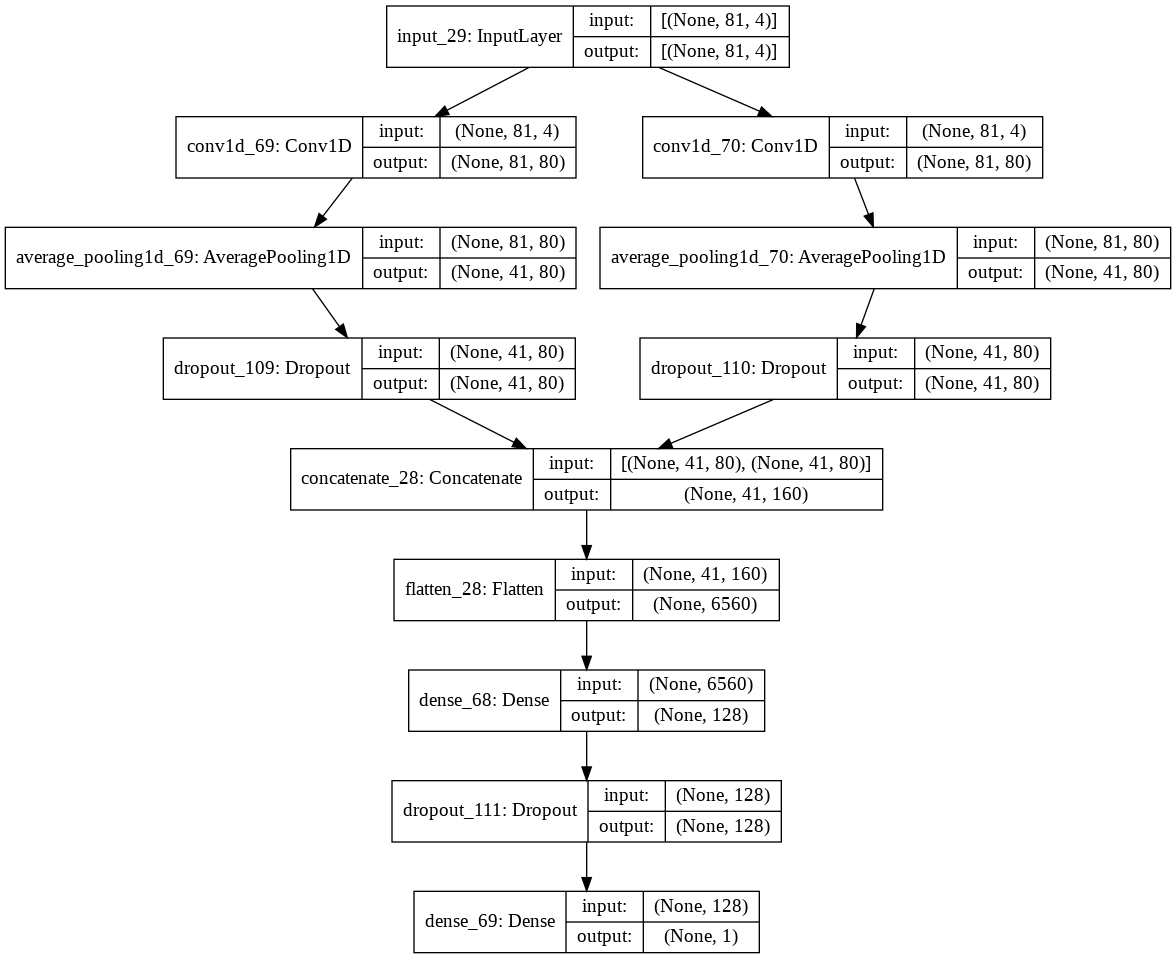

In [87]:
from tensorflow.keras.utils import plot_model
plot_model(model_promoter, to_file='model_promoter.png',show_shapes=True)
from IPython.display import Image
Image(filename='model_promoter.png')

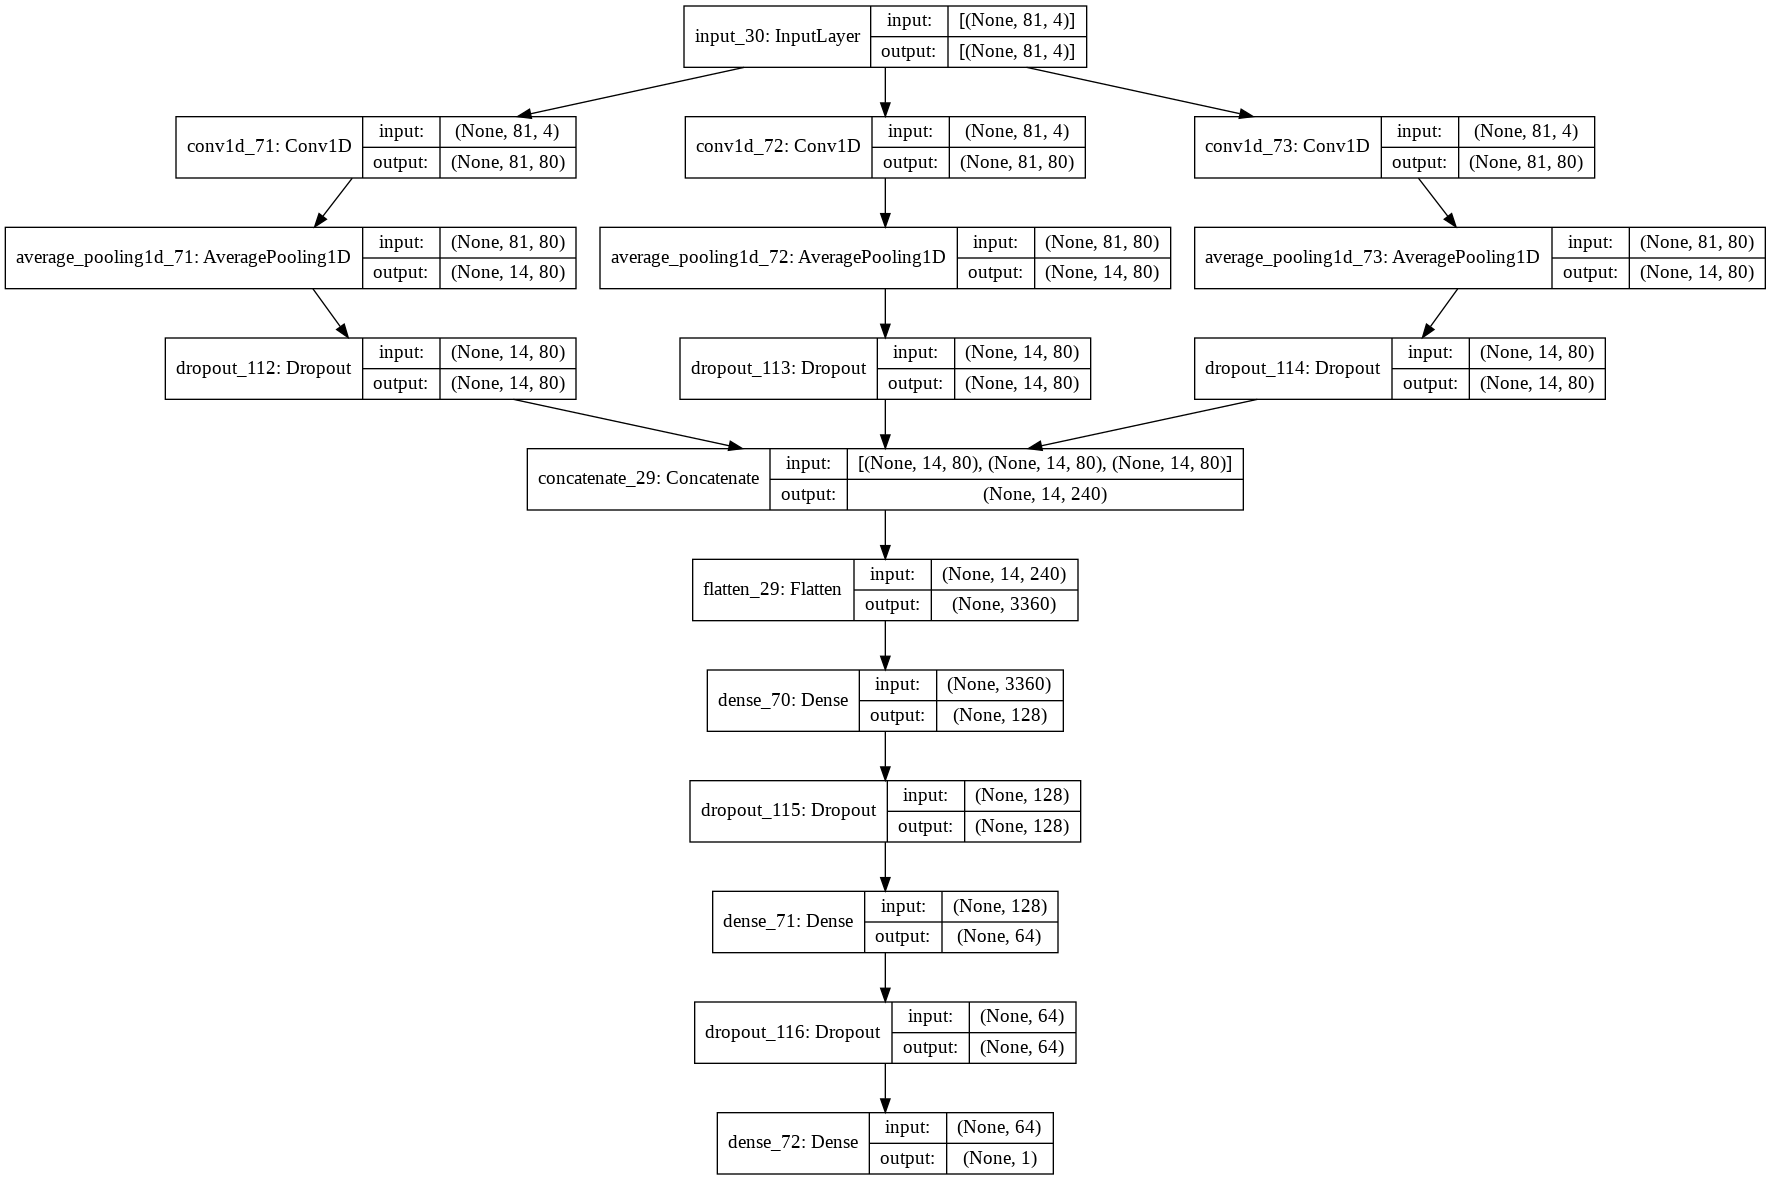

In [88]:
from tensorflow.keras.utils import plot_model
plot_model(model_strength, to_file='model_strength.png',show_shapes=True)
from IPython.display import Image
Image(filename='model_strength.png')

# Hiển thị trực hàm chính xác, độ mất mát

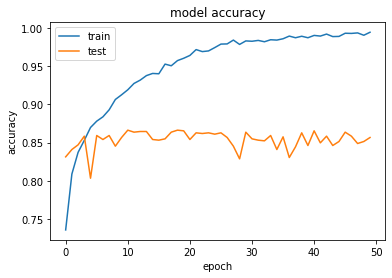

In [90]:
import matplotlib.pyplot as plt
plt.plot(history_promoter.history['accuracy'])
plt.plot(history_promoter.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

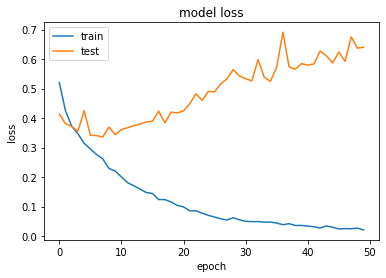

In [91]:
plt.plot(history_promoter.history['loss'])
plt.plot(history_promoter.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

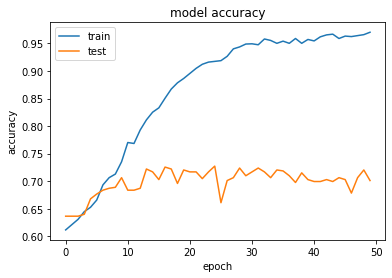

In [98]:
plt.plot(history_promoter_strength.history['accuracy'])
plt.plot(history_promoter_strength.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

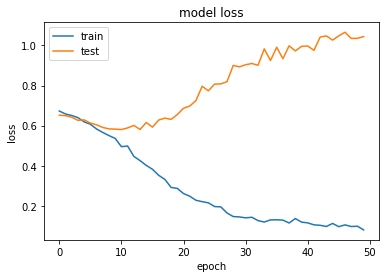

In [99]:
plt.plot(history_promoter_strength.history['loss'])
plt.plot(history_promoter_strength.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()